**Question 1**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
from pandas import Series, DataFrame

# def open_files():
#     directory = '/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/'
#     with open ('/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/all_data.txt', 'w') as output_file:
#         for data_file in os.listdir(directory):
#             if data_file != '.DS_Store':
#                 print('reading from ' + data_file)
#                 input_file_path = os.path.join(directory, data_file)            
#                 with open (input_file_path) as input_file:
#                     line = input_file.readline().strip()
#                     while line:
#                         output_line = line + '\t' + str(data_file) + '\n'
#                         output_file.write(output_line)
#                         line = input_file.readline().strip()
#                     input_file.close()
#         output_file.close()

# if __name__ == "__main__":
#     print('main')
#     open_files()
    

In [2]:
# read-in data
data = pd.read_csv('/Users/piper/Piper Documents/R and Python/Project 2/DataRaw/Diabetes-Data/all_data.txt', 
                   sep = '\t', header = None)
data_final = DataFrame(data)
data_final.columns = ['date', 'time', 'code', 'value', 'id']
data_final.shape

(29330, 5)

In [3]:
data_final.head()

,date,time,code,value,id
0,05-20-1991,08:00,58,101,data-31
1,05-20-1991,08:00,33,005,data-31
2,05-20-1991,08:00,34,027,data-31
3,05-20-1991,12:00,60,089,data-31
4,05-20-1991,12:00,33,003,data-31


In [4]:
# exlude data anomalies in data-29 and data-27
data_final = data_final[(data_final[['date','time',
                                     'code','value']] !='data-29' ).all(axis=1)]
data_final = data_final[(data_final[['date','time',
                                     'code','value']] !='data-27' ).all(axis=1)]
data_final.shape

(29264, 5)

In [5]:
# exclude rows with non-numerical values, total rows excluded = 8
data_final = data_final[(data_final[['value']] !='0Hi' ).all(axis=1)]
data_final = data_final[(data_final[['value']] !='0Lo' ).all(axis=1)]
data_final = data_final[(data_final[['value']] !="0''" ).all(axis=1)]
data_final.shape

(29256, 5)

In [6]:
# exclude outlier time points
data_final['Date'] = pd.to_datetime(data_final['date'], 
                                    errors = 'coerce')
data_final = data_final[(data_final['Date'] > '1980-01-01') & 
                        (data_final['Date'] < '2010-01-01')]
data_final.shape

(29249, 6)

In [7]:
# prep data for future project questions
# subset times into 'Part of Day' variable
string = data_final['time'].str.split(':', n = 1, expand = True) 
data_final['hour'] = pd.to_numeric(string[0])
data_final['minutes'] = pd.to_numeric(string[1])
data_final['total_minutes'] = data_final['hour']*60 + data_final['minutes']

# create 'Part-of-Day' variable
bins = [0, ((11*60) + 59), ((16*60) + 59), ((24*60))]
labels = ['Morning', 'Afternoon', 'Evening']
data_final['part_of_day'] = pd.cut(data_final['total_minutes'],
                                   bins=bins, labels=labels, include_lowest=True)

In [8]:
# realize there are 5 NaN's for part_of_day recorded times
data_final.isnull().sum(axis = 0) 

date             0
time             0
code             0
value            0
id               0
Date             0
hour             0
minutes          0
total_minutes    0
part_of_day      5
dtype: int64

In [9]:
# can see the inaccurately recorded times here
data_final.loc[:,('time', 'hour', 
                  'minutes')].sort_values(by='hour', ascending=False).head() 

,time,hour,minutes
17983,188:00,188,0
17982,188:00,188,0
17882,56:35,56,35
17881,56:35,56,35
17883,56:35,56,35


In [10]:
# drop NaN's, no. of rows with NaN's = 5
data_final = data_final.dropna(axis = 0)
data_final.shape # worked

(29244, 10)

In [11]:
# convert 'value' column to numeric
data_final['value'] = data_final.value.astype('float')

In [12]:
# delete uneeded columns
data_final.drop(['hour', 'minutes', 'total_minutes', 'Date'], 
                axis = 1, inplace = True)
data_final.head()

,date,time,code,value,id,part_of_day
0,05-20-1991,08:00,58,101.0,data-31,Morning
1,05-20-1991,08:00,33,5.0,data-31,Morning
2,05-20-1991,08:00,34,27.0,data-31,Morning
3,05-20-1991,12:00,60,89.0,data-31,Afternoon
4,05-20-1991,12:00,33,3.0,data-31,Afternoon


The original data set that included records for all 70 patients consisted of 29,330 rows of data. However, as can be seen from the work above, there was a substantial amount of data cleaning needed. First, data sets for patients 27 and 29 had some wrongly-recorded rows and were excluded from the final data set. Next, there seemed to be certian values recorded as "0Lo", "0Hi", and "0''", and these rows were also excluded. Also, after insepction, it was found that some of the dates recorded indicated that the data were collected around the year 1675. Thus, these rows were also excluded. Finally, in the process of creating the 'Part-of-Day' variable, it was discovered that there were certain times that were recorded outside of the 24-hour time period, and these were also excluded from the final data set. The column containing various measurement values was converted to a float dtype as well. The final data set included 29,244 rows. 

**Question 2**

In [13]:
# include only codes 58-63, glucose measurement codes
df_2 = data_final.loc[data_final['code'].isin(['58','59',
                                               '60','61',
                                               '62','63'])]
df_2 = df_2[['date', 'code', 'value']]

In [14]:
# obtain the median glucose, 25th percentiles, and 75th percentiles for each code
group_2 = df_2.groupby(['code'])
median = group_2.quantile(0.5)
low_p = group_2.quantile(0.25)
high_p = group_2.quantile(0.75)

In [15]:
# summarize in table below
table_2 = pd.concat([median, low_p, high_p], axis=1)
table_2.columns = ['Median Glucose', '25th','75th']
table_2['IQR'] = '('+table_2['25th'].astype(str)+', '+table_2['75th'].astype(str)+')'
table_2.drop(['25th', '75th'], axis = 1, inplace = True)

# change indices so I know what the code is refering to
table_2.rename(index = {'58':'Pre-Breakfast', 
                        '59':'Post-Breakfast', 
                        '60':'Pre-Lunch', 
                        '61':'Post-Lunch', 
                        '62':'Pre-Dinner', 
                        '63':'Post-Dinner'}, inplace = True)
del table_2.index.name
table_2

,Median Glucose,IQR
Pre-Breakfast,161.0,"(107.75, 223.0)"
Post-Breakfast,190.5,"(87.0, 230.0)"
Pre-Lunch,134.0,"(85.0, 187.0)"
Post-Lunch,225.0,"(177.0, 303.5)"
Pre-Dinner,147.0,"(99.0, 201.0)"
Post-Dinner,183.0,"(104.0, 257.0)"


The table above shows median pre and post-meal glucose levels and the corresponding IQRs for each. It can be seen that the highest median glucose levels are after lunch. Also, the median glucose levels seem to increase after eating a meal across all three meal types.  

**Question 3**

In [16]:
criteria = data_final.loc[data_final['code'].isin(['65','66',
                                                   '67','68',
                                                   '69','70',
                                                   '71','72'])].index
df_3 = data_final.loc[criteria, :]
group_3 = df_3.groupby(['id', 
                        'code', 'part_of_day']).size().reset_index(name='freq')
group_3['indicator'] = 1
group_3.drop(['freq'], axis = 1, inplace = True)

In [17]:
# table that sums up number of patients who had at least one 
# recording of the codes specified at given part-of-day
table_3 = pd.crosstab(group_3['code'], group_3['part_of_day'])

# change indices to know what code is refering to
table_3.rename(index = {'65':'Hypoglycemic Symptoms', 
                        '66':'Typical Meal Ingestion', 
                        '67':'More-than-Usual Meal Ingestion', 
                        '68':'Less-than-Usual Meal Ingestion', 
                        '69':'Typical Exercise Activity', 
                        '70':'More-than-Usual Exercise Activity',
                        '71':'Less-than-Usual Exercise Activity', 
                        '72':'Unspecified Special Event'}, inplace = True)
table_3 = table_3.rename_axis('').rename_axis('', axis = 1)
table_3

,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,31,20,22
Typical Meal Ingestion,11,9,8
More-than-Usual Meal Ingestion,30,15,32
Less-than-Usual Meal Ingestion,9,7,6
Typical Exercise Activity,10,6,14
More-than-Usual Exercise Activity,12,10,21
Less-than-Usual Exercise Activity,9,11,16
Unspecified Special Event,24,11,13


In [18]:
# divide each cell by 70 to get proportions, 
# also round to two decimal places
table_3b = (round((table_3/70)*100, 2)).astype(str)+' %'
table_3b

,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,44.29 %,28.57 %,31.43 %
Typical Meal Ingestion,15.71 %,12.86 %,11.43 %
More-than-Usual Meal Ingestion,42.86 %,21.43 %,45.71 %
Less-than-Usual Meal Ingestion,12.86 %,10.0 %,8.57 %
Typical Exercise Activity,14.29 %,8.57 %,20.0 %
More-than-Usual Exercise Activity,17.14 %,14.29 %,30.0 %
Less-than-Usual Exercise Activity,12.86 %,15.71 %,22.86 %
Unspecified Special Event,34.29 %,15.71 %,18.57 %


The two tables above show 1.) the number of patients that have had at least one recording of the specified variable types during specific parts of the day and 2.) the proportion/percentage of patients that have had at least one recording of the specified variable types during specific parts of the day. The denominator for each cell in table two is equal to 70. Here, it is interesting to note that just under half of all patients had at least one recording of hypoglycemic symptoms in the morning and at least one recording of more-than-ususal meal ingestion in the evening. 

**Question 4**

In [19]:
criteria = data_final.loc[data_final['code'].isin(['33', '34', '35'])].index
df_4 = data_final.loc[criteria, :]

In [20]:
# sum doses for patients with more than one dose of insulin type in same part-of-day
group_4 = df_4.groupby(['id', 'date', 'code', 
                        'part_of_day'])[['value']].sum() 

# drop NaN's
group_4 = group_4.dropna()

# reset index
group_4 = group_4.reset_index()

# change indices to know what codes are refering to
group_4['type'] = group_4['code'].replace({'33': 'Regular', 
                                           '34': 'NPH', 
                                           '35': 'UltraLente'})
group_4.drop(['code'], axis = 1, inplace = True)

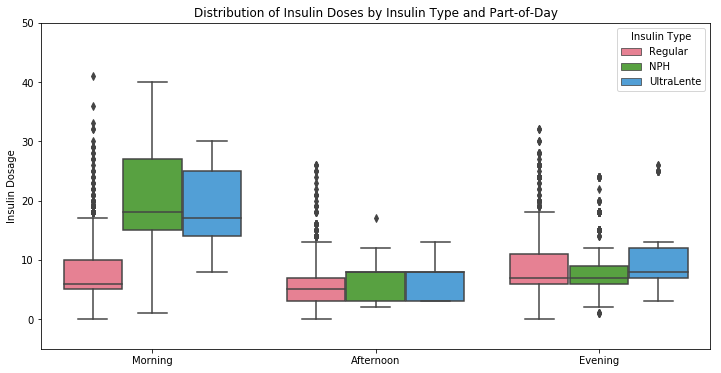

In [21]:
# boxplot by insulin type and part-of-day
plt.figure(figsize=(12,6))
sns.boxplot(x='part_of_day', y='value', hue='type', data=group_4, palette='husl')
plt.ylim(-5, 50)
plt.title('Distribution of Insulin Doses by Insulin Type and Part-of-Day')
plt.ylabel('Insulin Dosage')
plt.xlabel('')
plt.legend(title = 'Insulin Type')
plt.show()

The boxplot above shows the distribution of insulin dosage grouped by insulin type and part-of-day. From these boxplots, it can be seen that there is generally a wider range of insulin dosages across the three different insulin types in the morning compared to other periods of the day, respectively. Also, the "regular" insulin type seems to have a larger number of outliers compared to the "NPH" and "UltraLente" insulin types. 

**Question 5**

In [22]:
criteria = data_final.loc[data_final['code'].isin(['58','59','60',
                                                   '61','62','63'])].index
df_5 = data_final.loc[criteria, :]
df_5['Date'] = pd.to_datetime(df_5['date'], errors = 'coerce')
df_5['time'] = [x + ':00' for x in df_5['time']]
df_5['Time'] = pd.to_timedelta(df_5['time'].astype(str))

# get datetime variable for plotting purposes
df_5['datetime'] = pd.to_datetime(df_5['Date']+df_5['Time'])

# drop unneeded variables
df_5.drop(['date', 'time', 'Date', 'Time'], axis = 1, inplace = True)

In [23]:
# create pre-post variable
df_5['pre_post'] = ['Pre' if x == '58' or x == '60' or x == '62' 
                    else 'Post' for x in df_5['code']]

In [24]:
# create ordinal datetime variable for plot
df_5['datetime_ordinal'] = df_5['datetime'].apply(lambda date: date.toordinal())

In [25]:
# create data subsets for pre and post-breakfast, lunch, & dinner
df_5_b = df_5.loc[df_5['code'].isin(['58', '59'])]
df_5_b_pre = df_5_b.loc[df_5_b['pre_post'].isin(['Pre'])]
df_5_b_post = df_5_b.loc[df_5_b['pre_post'].isin(['Post'])]

df_5_l = df_5.loc[df_5['code'].isin(['60', '61'])]
df_5_l_pre = df_5_l.loc[df_5_l['pre_post'].isin(['Pre'])]
df_5_l_post = df_5_l.loc[df_5_l['pre_post'].isin(['Post'])]

df_5_d = df_5.loc[df_5['code'].isin(['62', '63'])]
df_5_d_pre = df_5_d.loc[df_5_d['pre_post'].isin(['Pre'])]
df_5_d_post = df_5_d.loc[df_5_d['pre_post'].isin(['Post'])]

In [26]:
# prepare lowess curves
lowess1 = lowess(exog=df_5_b_pre['datetime_ordinal'], 
                 endog=df_5_b_pre['value'])
lowess2 = lowess(exog=df_5_b_post['datetime_ordinal'], 
                 endog=df_5_b_post['value'])

lowess3 = lowess(exog=df_5_l_pre['datetime_ordinal'], 
                 endog=df_5_l_pre['value'])
lowess4 = lowess(exog=df_5_l_post['datetime_ordinal'], 
                 endog=df_5_l_post['value'])

lowess5 = lowess(exog=df_5_d_pre['datetime_ordinal'], 
                 endog=df_5_d_pre['value'])
lowess6 = lowess(exog=df_5_d_post['datetime_ordinal'], 
                 endog=df_5_d_post['value'])

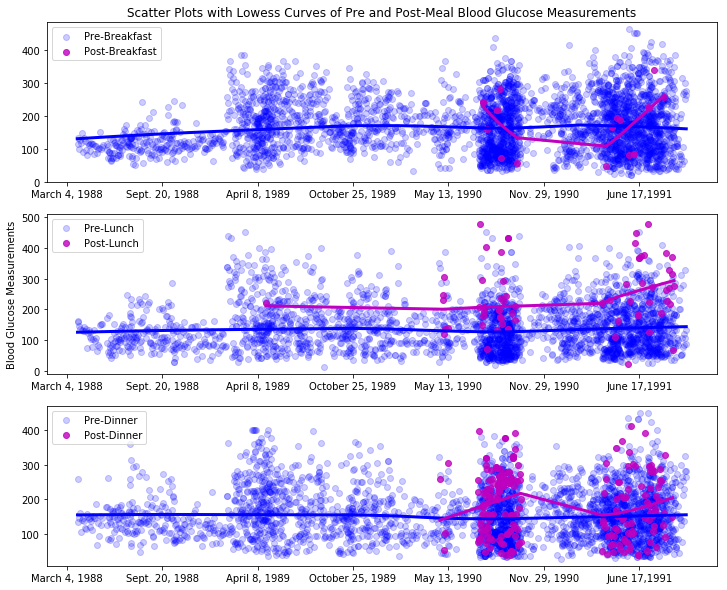

In [27]:
# plot scatterplot of glucose measurement values over time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12,10))

ax1.scatter(df_5_b_pre.loc[:,'datetime_ordinal'], 
            df_5_b_pre.loc[:,'value'], color='b', alpha = 0.2)
ax1.scatter(df_5_b_post.loc[:,'datetime_ordinal'], 
            df_5_b_post.loc[:,'value'], color='m', alpha = 0.8)
ax1.plot(lowess1[:,0], lowess1[:,1], color='b', linewidth = 3)
ax1.plot(lowess2[:,0], lowess2[:,1], color='m', linewidth = 3)
leg_handles = ax1.get_legend_handles_labels()[0]
ax1.legend(leg_handles, ['Pre-Breakfast', 'Post-Breakfast'])

ax2.scatter(df_5_l_pre.loc[:,'datetime_ordinal'], 
            df_5_l_pre.loc[:,'value'], color='b', alpha = 0.2)
ax2.scatter(df_5_l_post.loc[:,'datetime_ordinal'], 
            df_5_l_post.loc[:,'value'], color='m', alpha = 0.8)
ax2.plot(lowess3[:,0], lowess3[:,1], color='b', linewidth = 3)
ax2.plot(lowess4[:,0], lowess4[:,1], color='m', linewidth = 3)
leg_handles = ax2.get_legend_handles_labels()[0]
ax2.legend(leg_handles, ['Pre-Lunch', 'Post-Lunch'])

ax3.scatter(df_5_d_pre.loc[:,'datetime_ordinal'], 
            df_5_d_pre.loc[:,'value'], color='b', alpha = 0.2)
ax3.scatter(df_5_d_post.loc[:,'datetime_ordinal'], 
            df_5_d_post.loc[:,'value'], color='m', alpha = 0.8)
ax3.plot(lowess5[:,0], lowess5[:,1], color='b', linewidth = 3)
ax3.plot(lowess6[:,0], lowess6[:,1], color='m', linewidth = 3)
leg_handles = ax3.get_legend_handles_labels()[0]
ax3.legend(leg_handles, ['Pre-Dinner', 'Post-Dinner'])

ticks = [725800, 726000, 726200, 726400, 726600, 726800, 727000]
xlabs = ['March 4, 1988', 
         'Sept. 20, 1988', 
         'April 8, 1989', 
         'October 25, 1989', 
         'May 13, 1990', 
         'Nov. 29, 1990', 
         'June 17,1991']
ax1.set_xticks(ticks)
ax1.set_xticklabels(xlabs)
ax2.set_xticks(ticks)
ax2.set_xticklabels(xlabs)
ax3.set_xticks(ticks)
ax3.set_xticklabels(xlabs)

plt.ylabel('Blood Glucose Measurements', y=1.7)
plt.title('Scatter Plots with Lowess Curves of Pre and Post-Meal Blood Glucose Measurements', y=3.4)
plt.show()

The scatter plots above include lowess curves fit to the pre and post-meal scatter plot points for breakfast, lunch, and dinner. The curves, as expected, are not as smooth as cubic smoothing splines. However, the general patterns are still accurately captured. In general, it seems that post-meal measurements were not taken until approximately May 1990. Also, pre-meal blood glucose measurements over time did not seem to drastically change. However, post-meal blood glucose measurements seemed to fluctuate more. These fluctuations are likely due to the limited number of data points for post-meal measurements. 

**Question 6**

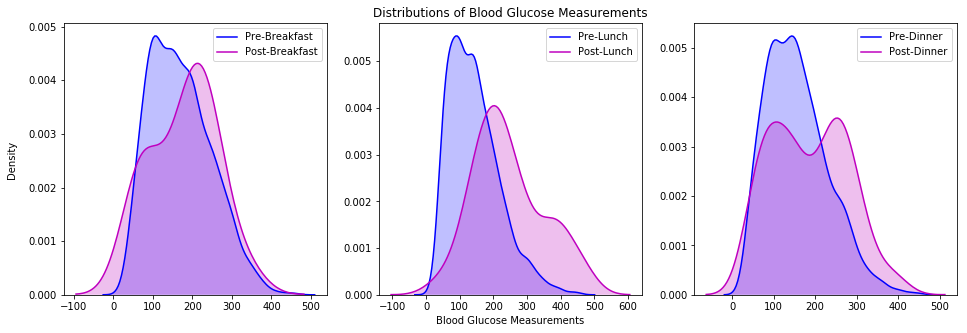

In [28]:
# use same data sets from question 5
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,5))

sns.kdeplot(df_5_b_pre['value'], shade=True, color="b", ax=ax1)
sns.kdeplot(df_5_b_post['value'], shade=True, color="m", ax=ax1)
leg_handles = ax1.get_legend_handles_labels()[0]
ax1.legend(leg_handles, ['Pre-Breakfast', 'Post-Breakfast'])

sns.kdeplot(df_5_l_pre['value'], shade=True, color="b", ax=ax2)
sns.kdeplot(df_5_l_post['value'], shade=True, color="m", ax=ax2)
leg_handles = ax2.get_legend_handles_labels()[0]
ax2.legend(leg_handles, ['Pre-Lunch', 'Post-Lunch'])

sns.kdeplot(df_5_d_pre['value'], shade=True, color="b", ax=ax3)
sns.kdeplot(df_5_d_post['value'], shade=True, color="m", ax=ax3)
leg_handles = ax3.get_legend_handles_labels()[0]
ax3.legend(leg_handles, ['Pre-Dinner', 'Post-Dinner'])

plt.xlabel('Blood Glucose Measurements', x=-0.7)
fig.text(0.08, 0.5, 'Density', ha='center', va='center', rotation=90)
plt.title('Distributions of Blood Glucose Measurements', x=-0.7)
plt.show()

The distributions of pre and post-meal blood glucose measurements for breakfast, lunch and dinner are shown above. From these plots, the mean pre-meal blood glucose levels appear to be smaller than post-meal blood glucose measurements. Also, for all pre and post-meal distributions, there seems to be a somewhat bimodal distribution. Also, these plots indicate that there were some negative blood glucose measurements taken. However, I am not sure if this possible. I would likely bring this up with the primary investigator as a potential measurement error.  